In [8]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
from riotwatcher import RiotWatcher
import requests

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

# Get matchids for challenger tier players
because there is no api call to just get a bunch matches I have to do some weird stuff. My strategy is: get challenger player list from the region -> getsummoner by playerid to get accountid -> get recent matches from each player -> check duplicates -> get match details

also can swap challenger to masters p easy. swapping to lower leagues is a bit harder


In [35]:
regions = ['RU','KR', 'BR1', 'OC1', 'JP1', 'NA1', 'EUN1', 'EUW1', 'TR1', 'LA1', 'LA2']
#regions = ['LA1', 'LA2']

#gameid_list = {}
league_items = {}

#choose tier, division, and queue
#for tier lower than master need to get league codes then get league items
#valid tiers CHALLENGER, MASTERS, DIAMOND, PLATINUM, GOLD, SILVER, BRONZE, IRON
#valid divisions I, II, III, IV
tier = 'DIAMOND'
division = 'I'
queue = 'RANKED_SOLO_5x5'

#get last challenger games for each player in each region (purge duplicates)
#first loop through regions
for region in regions:
    league_items[region] = []
    
    #get all 'items' in the challenger league for solo queue (not sure about 'flex' queues?)
    #changed to master tier because that is the highest until mid january
    if tier=='CHALLENGER':
        league_items[region] = watcher.league.challenger_by_queue(region, queue)['entries']
    elif tier=='MASTERS':
        league_items[region] = watcher.league.masters_by_queue(region,queue)['entries']
    else:
        #this entries method doesn't exist yet (as of 20190428)
        league_codes = watcher.league.entries(region, 'RANKED_SOLO_5x5',tier)
        for league in league_codes:
                leagues_items[region].append(watcher.league.by_id(region,league)['entries'])

    #initialize gameid_list items
    gameid_list[region] = []

#loop through all items in each region's league to get matchid's
for region in regions:
    print(region)

    #get 100 matches from each player  
    for entry in league_items[region]:

        #convert player_id(aka summoner_id) to account_id
        account_id = watcher.summoner.by_id(region, entry['summonerId'])['accountId']

        #don't keep all matches in memory or on disk - we will get full match details later
        #queue = 420 is the code for 5x5_solo_queue
        match_list = watcher.match.matchlist_by_account(region,
                                     account_id,
                                     queue=420,
                                     begin_index = 1,
                                     end_index=100)['matches']
            
        #keep gameid_list in memory for later use and for easy purging of duplicates
        for match in match_list:
            gameid_list[region].append(match['gameId']) 

        #purge duplicates from gameid_list
        gameid_list[region] = list(set(gameid_list[region]))

       

AttributeError: 'LeagueApiV4' object has no attribute 'entries'

In [45]:
with open(os.path.join('LOL_data','challenger_tier','saved'+time.strftime('%Y-%m-%d')+'.json'), 'w') as fp:
    json.dump(gameid_list, fp)

# Get match details

## Load data into dataframe
Do this from a file. Also reindex DF so that we can hopefully call each region in a mixed rather than sequential way

In [10]:
#get all files in challenger_tier data folder, then sort by date
files = glob.glob(os.path.join('LOL_data','*','*.json'))
files.sort(key=os.path.getmtime)
print(files)

['LOL_data/masters_tier/2018-12-14.json', 'LOL_data/masters_tier/saved2018-12-22.json', 'LOL_data/challenger_tier/saved2019-04-08.json', 'LOL_data/masters_tier/saved2019-04-10.json']


In [40]:
lol_df = pd.DataFrame()
region_list = []
gameid_load_list = []

with open(files[-1],'r') as fp:
    for key, item in json.load(fp).items():
        region_list.extend([key] * len(item))
        gameid_load_list.extend(item)
        
lol_df['region'] = region_list
lol_df['gameid'] = gameid_load_list
lol_df.describe()

,gameid
count,1.756140e+05
mean,2.904429e+09
std,9.480713e+08
min,1.904688e+08
25%,2.144003e+09
50%,3.013737e+09
75%,3.612617e+09
max,3.992113e+09


In [41]:
#reindex randomly so that we don't loop through regions sequentially
#this way we more efficiently use the api calls we're allotted
lol_df = lol_df.reindex(np.random.permutation(lol_df.index))

## Get match details from riotwatcher api

In [59]:
blue_win = []
red_gold = []
blue_gold = []
blue_tower_kills=[]
red_tower_kills=[]
blue_inhibitor_kills=[]
red_inhibitor_kills=[]
blue_baron_kills=[]
red_baron_kills=[]
blue_dragon_kills=[]
red_dragon_kills=[]
blue_champs = []
red_champs = []
bad_element_list = []
region_list = []
gameid_list = []
for i,row in lol_df[:].iterrows():
    
    #NOTE: Summoner spell info is included in match_details but may be hard to keep linked to participants
    #NOTE 2: Timeline info. can give timeline info on many things for teams and individual participants
    #   this could be used for training  a real time win probability model.
    try:
        match_details = watcher.match.by_id(row['region'],row['gameid'])   
    except requests.exceptions.HTTPError as err:
        print(err)
        print('Error at row:',row['gameid'])
        print('element:',i)
        bad_element_list.append(i)
        continue
        
    #skip element and mark as bad element if not 10 team members
    if len(match_details['participants'])!=10:
        bad_element_list.append(i)
        continue
    #append region_list and gameid_list so we don't have to
    #deal with wrong bad region, gameid
    region_list.append(row['region'])
    gameid_list.append(row['gameid'])
    
    #blue win is true if teamid=100 (blue) and this same team won
    blue_win.append(int(match_details['teams'][0]['win']=='Win' and match_details['teams'][0]['teamId']==100))

    #add blue gold and red gold (at end of match) to lists
    #intention for this is to take the difference then normalize by the total (to control for long vs. short games)
    blue_gold_match = 0
    red_gold_match = 0
    for participant in match_details['participants']:
        if len(match_details['participants'])!=10:
            bad_element_list.append(i)
            break
        if participant['teamId']==100:
            blue_gold_match+=participant['stats']['goldEarned']
        else:
            red_gold_match+=participant['stats']['goldEarned']
    blue_gold.append(blue_gold_match)
    red_gold.append(red_gold_match)
    
    #add blue and red tower kills (at end of match) to lists
    #should take difference and normalize by the total towers
    blue_tower_kills.append(match_details['teams'][0]['towerKills'])
    red_tower_kills.append(match_details['teams'][1]['towerKills'])
    
    #add blue and red tower kills (at end of match) to lists
    #should take difference and normalize by the total towers
    blue_inhibitor_kills.append(match_details['teams'][0]['inhibitorKills'])
    red_inhibitor_kills.append(match_details['teams'][1]['inhibitorKills'])
    
    #add blue and red tower kills (at end of match) to lists
    #like gold, should take diff and normalize
    blue_baron_kills.append(match_details['teams'][0]['baronKills'])
    red_baron_kills.append(match_details['teams'][1]['baronKills'])
    
    #add blue and red dragon kills (at end of match) to lists
    #like gold, the intention of this is to take the difference and normalize
    blue_dragon_kills.append(match_details['teams'][0]['dragonKills'])
    red_dragon_kills.append(match_details['teams'][1]['dragonKills'])

    #build team champion lineups and append to columns
    blue_champ_row = []
    red_champ_row = []
    for participant in match_details['participants']:
        if participant['teamId'] == 100:
            blue_champ_row.append(participant['championId'])
        elif participant['teamId'] ==200:
            red_champ_row.append(participant['championId'])
        else:
            print('Illegal team value!',participant['teamId'])
            break
    blue_champs.append(blue_champ_row)
    red_champs.append(red_champ_row)    

503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3010700470
Error at row: 3010700470
element: 69801
429 Client Error: Too Many Requests for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2128288360
Error at row: 2128288360
element: 111847
429 Client Error: Too Many Requests for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3984463745
Error at row: 3984463745
element: 136764
504 Server Error: Gateway Timeout for url: https://kr.api.riotgames.com/lol/match/v4/matches/3590993137
Error at row: 3590993137
element: 4730
429 Client Error: Too Many Requests for url: https://kr.api.riotgames.com/lol/match/v4/matches/3610250440
Error at row: 3610250440
element: 1169
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3598743513
Error at row: 3598743513
element: 10943
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2160407081
Error a

500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1623611096
Error at row: 1623611096
element: 56330
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2128317388
Error at row: 2128317388
element: 123217
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3584851429
Error at row: 3584851429
element: 11498
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3582606883
Error at row: 3582606883
element: 5583
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2907304956
Error at row: 2907304956
element: 81749
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2885661816
Error at row: 2885661816
element: 72164
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2993843977
Error at row: 2993843977
element: 81000
500 Ser

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3601812595
Error at row: 3601812595
element: 30728
500 Server Error: Server Error for url: https://la2.api.riotgames.com/lol/match/v4/matches/683726658
Error at row: 683726658
element: 175543
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2998272977
Error at row: 2998272977
element: 64866
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3601416136
Error at row: 3601416136
element: 29582
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1596009862
Error at row: 1596009862
element: 51803
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3917905726
Error at row: 3917905726
element: 144164
500 Server Error: Server Error for url: https://tr1.api.riotgames.com/lol/match/v4/matches/806801425
Error at row: 806801425
element: 173146
500 Serv

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3987546412
Error at row: 3987546412
element: 155858
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3600753407
Error at row: 3600753407
element: 26916
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3599539689
Error at row: 3599539689
element: 14529
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3974907321
Error at row: 3974907321
element: 140105
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3951620682
Error at row: 3951620682
element: 152484
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3597975865
Error at row: 3597975865
element: 17672
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3980690464
Error at row: 3980690464
element: 144513
5

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2134836217
Error at row: 2134836217
element: 109548
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2128931931
Error at row: 2128931931
element: 107194
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2998568557
Error at row: 2998568557
element: 65277
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2140596054
Error at row: 2140596054
element: 106700
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3591661451
Error at row: 3591661451
element: 9373
429 Client Error: Too Many Requests for url: https://na1.api.riotgames.com/lol/match/v4/matches/3012860554
Error at row: 3012860554
element: 68242
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2159016034
Error at row: 2159016034
element: 13

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2141499196
Error at row: 2141499196
element: 101057
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3588755328
Error at row: 3588755328
element: 1420
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3601428870
Error at row: 3601428870
element: 34042
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3521352145
Error at row: 3521352145
element: 37106
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2134373489
Error at row: 2134373489
element: 133945
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2994724802
Error at row: 2994724802
element: 78661
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3604605110
Error at row: 3604605110
element: 44809
500 Ser

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2145915251
Error at row: 2145915251
element: 85291
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3521590533
Error at row: 3521590533
element: 28601
429 Client Error: Too Many Requests for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3968801976
Error at row: 3968801976
element: 155492
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2996184897
Error at row: 2996184897
element: 70183
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3937735981
Error at row: 3937735981
element: 154958
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2155898083
Error at row: 2155898083
element: 93646
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3959465310
Error at row: 3959465310
element: 1

500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3006052089
Error at row: 3006052089
element: 72528
429 Client Error: Too Many Requests for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2131817435
Error at row: 2131817435
element: 107921
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3602607971
Error at row: 3602607971
element: 33842
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3607763119
Error at row: 3607763119
element: 2215
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2148846295
Error at row: 2148846295
element: 103831
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3574279119
Error at row: 3574279119
element: 27752
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3599190444
Error at row: 3599190444
element: 30489
50

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3572781073
Error at row: 3572781073
element: 7183
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3969713549
Error at row: 3969713549
element: 153868
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3918356183
Error at row: 3918356183
element: 160164
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3528619259
Error at row: 3528619259
element: 10668
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2123811192
Error at row: 2123811192
element: 103683
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3009013901
Error at row: 3009013901
element: 80031
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1624801529
Error at row: 1624801529
element: 46977
500

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3978226308
Error at row: 3978226308
element: 151944
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2128907726
Error at row: 2128907726
element: 97642
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3574428111
Error at row: 3574428111
element: 34073
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3607522257
Error at row: 3607522257
element: 9756
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3989268688
Error at row: 3989268688
element: 160917
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3607375887
Error at row: 3607375887
element: 4317
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2974935278
Error at row: 2974935278
element: 80079
500 Se

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3989409734
Error at row: 3989409734
element: 163805
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3938930013
Error at row: 3938930013
element: 158986
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3610751492
Error at row: 3610751492
element: 39938
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2126038387
Error at row: 2126038387
element: 103318
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3597182068
Error at row: 3597182068
element: 15079
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1627329964
Error at row: 1627329964
element: 49214
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3970567646
Error at row: 3970567646
element: 136082


500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2164567416
Error at row: 2164567416
element: 100838
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3406904182
Error at row: 3406904182
element: 29194
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3927587815
Error at row: 3927587815
element: 139422
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3601400213
Error at row: 3601400213
element: 23788
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2126300933
Error at row: 2126300933
element: 103454
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3592954456
Error at row: 3592954456
element: 3059
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2992754101
Error at row: 2992754101
element: 75984
500 

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2140740109
Error at row: 2140740109
element: 111802
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2156270964
Error at row: 2156270964
element: 85699
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2994184090
Error at row: 2994184090
element: 69045
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3595310843
Error at row: 3595310843
element: 2056
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3944257864
Error at row: 3944257864
element: 146040
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2141614271
Error at row: 2141614271
element: 94829
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3015502613
Error at row: 3015502613
element: 80399
42

500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1604866181
Error at row: 1604866181
element: 55655
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2163669735
Error at row: 2163669735
element: 108622
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3592607927
Error at row: 3592607927
element: 19865
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3615007026
Error at row: 3615007026
element: 14798
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3581166838
Error at row: 3581166838
element: 6164
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2139814438
Error at row: 2139814438
element: 108555
429 Client Error: Too Many Requests for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2161241846
Error at row: 2161241846
element: 133385

429 Client Error: Too Many Requests for url: https://tr1.api.riotgames.com/lol/match/v4/matches/821707005
Error at row: 821707005
element: 172272
429 Client Error: Too Many Requests for url: https://na1.api.riotgames.com/lol/match/v4/matches/3017889686
Error at row: 3017889686
element: 77465
429 Client Error: Too Many Requests for url: https://kr.api.riotgames.com/lol/match/v4/matches/3582734926
Error at row: 3582734926
element: 4531
429 Client Error: Too Many Requests for url: https://kr.api.riotgames.com/lol/match/v4/matches/3616103626
Error at row: 3616103626
element: 32147
429 Client Error: Too Many Requests for url: https://br1.api.riotgames.com/lol/match/v4/matches/1626252876
Error at row: 1626252876
element: 51057
429 Client Error: Too Many Requests for url: https://kr.api.riotgames.com/lol/match/v4/matches/3561542573
Error at row: 3561542573
element: 19383
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3604945600
Error at row: 36049456

503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3981416552
Error at row: 3981416552
element: 164438
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2149080268
Error at row: 2149080268
element: 92818
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2163787911
Error at row: 2163787911
element: 103606
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3603373318
Error at row: 3603373318
element: 26339
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3948608245
Error at row: 3948608245
element: 153104
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2126599611
Error at row: 2126599611
element: 117694
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches

503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3984744099
Error at row: 3984744099
element: 141854
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3986380640
Error at row: 3986380640
element: 159651
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2118635626
Error at row: 2118635626
element: 130192
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3952457246
Error at row: 3952457246
element: 166603
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/2998757998
Error at row: 2998757998
element: 80286
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2160001283
Error at row: 2160001283
element: 109254
503 Server Error: Service Unavailable for url: https://br1.api.riotgames.com/lol/match/v4/matche

503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3609301198
Error at row: 3609301198
element: 36989
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3017348567
Error at row: 3017348567
element: 72373
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3590441819
Error at row: 3590441819
element: 42203
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3586696962
Error at row: 3586696962
element: 15283
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3953093173
Error at row: 3953093173
element: 161007
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/1925142311
Error at row: 1925142311
element: 117820
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/36047589

503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2159862986
Error at row: 2159862986
element: 106451
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2142207965
Error at row: 2142207965
element: 121955
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3922586025
Error at row: 3922586025
element: 170538
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2163283563
Error at row: 2163283563
element: 111416
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3006529765
Error at row: 3006529765
element: 64408
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2147189028
Error at row: 2147189028
element: 122091
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matche

503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3982693842
Error at row: 3982693842
element: 154999
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/2983707875
Error at row: 2983707875
element: 74652
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3007661170
Error at row: 3007661170
element: 74583
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3602525041
Error at row: 3602525041
element: 3916
503 Server Error: Service Unavailable for url: https://oc1.api.riotgames.com/lol/match/v4/matches/237183769
Error at row: 237183769
element: 61121
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3972836182
Error at row: 3972836182
element: 147343
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3958099

503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3946908106
Error at row: 3946908106
element: 154176
503 Server Error: Service Unavailable for url: https://br1.api.riotgames.com/lol/match/v4/matches/1595332121
Error at row: 1595332121
element: 56237
503 Server Error: Service Unavailable for url: https://br1.api.riotgames.com/lol/match/v4/matches/1628302862
Error at row: 1628302862
element: 58825
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3607666336
Error at row: 3607666336
element: 14586
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3007186699
Error at row: 3007186699
element: 65366
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2151036671
Error at row: 2151036671
element: 89057
503 Server Error: Service Unavailable for url: https://oc1.api.riotgames.com/lol/match/v4/matches/237236

503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3583493958
Error at row: 3583493958
element: 41796
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2118134352
Error at row: 2118134352
element: 87846
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3614125232
Error at row: 3614125232
element: 27835
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3008194724
Error at row: 3008194724
element: 80044
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2131984206
Error at row: 2131984206
element: 121895
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3591332908
Error at row: 3591332908
element: 32809
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2148179

503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/2989254069
Error at row: 2989254069
element: 79596
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3950159028
Error at row: 3950159028
element: 146859
503 Server Error: Service Unavailable for url: https://br1.api.riotgames.com/lol/match/v4/matches/1627053654
Error at row: 1627053654
element: 57160
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3588197656
Error at row: 3588197656
element: 36616
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3613780843
Error at row: 3613780843
element: 45049
503 Server Error: Service Unavailable for url: https://tr1.api.riotgames.com/lol/match/v4/matches/816722785
Error at row: 816722785
element: 173324
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/21381404

503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3786729675
Error at row: 3786729675
element: 151807
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152959928
Error at row: 2152959928
element: 123619
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/2993424612
Error at row: 2993424612
element: 65644
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2156496777
Error at row: 2156496777
element: 122752
503 Server Error: Service Unavailable for url: https://br1.api.riotgames.com/lol/match/v4/matches/1598470215
Error at row: 1598470215
element: 53005
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3001012790
Error at row: 3001012790
element: 76655
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3

503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3990679524
Error at row: 3990679524
element: 152312
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3011651779
Error at row: 3011651779
element: 70394
503 Server Error: Service Unavailable for url: https://br1.api.riotgames.com/lol/match/v4/matches/1616614419
Error at row: 1616614419
element: 49042
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152696809
Error at row: 2152696809
element: 123231
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3588652626
Error at row: 3588652626
element: 11532
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2126585057
Error at row: 2126585057
element: 112112
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/39

503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2143500032
Error at row: 2143500032
element: 114664
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3974333175
Error at row: 3974333175
element: 162877
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3968857704
Error at row: 3968857704
element: 171462
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3956796628
Error at row: 3956796628
element: 170751
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2132400886
Error at row: 2132400886
element: 131314
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2072331662
Error at row: 2072331662
element: 116105
503 Server Error: Service Unavailable for url: https://oc1.api.riotgames.com/lol/match/v4/matc

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3570156072
Error at row: 3570156072
element: 5924
429 Client Error: Too Many Requests for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3981714733
Error at row: 3981714733
element: 137763
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2154063467
Error at row: 2154063467
element: 93808
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2130213919
Error at row: 2130213919
element: 95953
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3595394919
Error at row: 3595394919
element: 32361
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2122147736
Error at row: 2122147736
element: 119426
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2995285246
Error at row: 2995285246
element: 8068

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2151488059
Error at row: 2151488059
element: 111829
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2139322509
Error at row: 2139322509
element: 121226
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2978393040
Error at row: 2978393040
element: 70838
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3568309029
Error at row: 3568309029
element: 1733
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2117435388
Error at row: 2117435388
element: 121973
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1584596086
Error at row: 1584596086
element: 47368
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3976414298
Error at row: 3976414298
element: 158334


500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3941159980
Error at row: 3941159980
element: 159445
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3610924207
Error at row: 3610924207
element: 7594
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152980063
Error at row: 2152980063
element: 131666
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2146096590
Error at row: 2146096590
element: 104948
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3590657871
Error at row: 3590657871
element: 25796
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3953241702
Error at row: 3953241702
element: 166037
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3954075981
Error at row: 3954075981
element: 142617

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3590476912
Error at row: 3590476912
element: 7576
500 Server Error: Server Error for url: https://oc1.api.riotgames.com/lol/match/v4/matches/231115829
Error at row: 231115829
element: 62106
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2990858189
Error at row: 2990858189
element: 78666
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3979155763
Error at row: 3979155763
element: 155253
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1616627933
Error at row: 1616627933
element: 54825
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3976938877
Error at row: 3976938877
element: 158410
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2145850154
Error at row: 2145850154
element: 111088
500 

500 Server Error: Server Error for url: https://la2.api.riotgames.com/lol/match/v4/matches/679926345
Error at row: 679926345
element: 175131
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2154796713
Error at row: 2154796713
element: 124352
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2153709015
Error at row: 2153709015
element: 108958
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2153611066
Error at row: 2153611066
element: 121889
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2150368684
Error at row: 2150368684
element: 84155
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1551475085
Error at row: 1551475085
element: 50555
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2028114154
Error at row: 2028114154
element: 97951

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2138072533
Error at row: 2138072533
element: 93739
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3882204781
Error at row: 3882204781
element: 167242
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2163747456
Error at row: 2163747456
element: 87870
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3525720730
Error at row: 3525720730
element: 5288
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3601410774
Error at row: 3601410774
element: 27669
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2164521932
Error at row: 2164521932
element: 134726
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2997810111
Error at row: 2997810111
element: 81711
500

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2120920213
Error at row: 2120920213
element: 100747
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2154511688
Error at row: 2154511688
element: 115273
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3583987312
Error at row: 3583987312
element: 30909
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3617063092
Error at row: 3617063092
element: 56
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2159980816
Error at row: 2159980816
element: 101234
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2137156235
Error at row: 2137156235
element: 94210
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2117529245
Error at row: 2117529245
element: 107414
50

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3941557779
Error at row: 3941557779
element: 160711
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2115941174
Error at row: 2115941174
element: 101440
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3731604419
Error at row: 3731604419
element: 167611
500 Server Error: Server Error for url: https://oc1.api.riotgames.com/lol/match/v4/matches/232655057
Error at row: 232655057
element: 61749
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2961370810
Error at row: 2961370810
element: 80945
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2960231499
Error at row: 2960231499
element: 66122
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2144733957
Error at row: 2144733957
element: 84696
5

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3366710002
Error at row: 3366710002
element: 44996
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3583566214
Error at row: 3583566214
element: 20723
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1627503880
Error at row: 1627503880
element: 53549
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3975558271
Error at row: 3975558271
element: 138876
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3972192505
Error at row: 3972192505
element: 150644
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3592144756
Error at row: 3592144756
element: 41815
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2162544170
Error at row: 2162544170
element: 129968
500

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2155530143
Error at row: 2155530143
element: 103514
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1622662044
Error at row: 1622662044
element: 56863
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3948572867
Error at row: 3948572867
element: 143143
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2159298079
Error at row: 2159298079
element: 90563
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1612146953
Error at row: 1612146953
element: 58312
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2153067291
Error at row: 2153067291
element: 114299
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2135058464
Error at row: 2135058464
element: 9398

429 Client Error: Too Many Requests for url: https://na1.api.riotgames.com/lol/match/v4/matches/3013593137
Error at row: 3013593137
element: 75165
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3936785931
Error at row: 3936785931
element: 145787
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3974740573
Error at row: 3974740573
element: 166931
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3906485086
Error at row: 3906485086
element: 139380
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2144854620
Error at row: 2144854620
element: 132045
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3986334034
Error at row: 3986334034
element: 146622
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3949995795
Error at row: 3949995795
eleme

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3614135348
Error at row: 3614135348
element: 31400
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3611074688
Error at row: 3611074688
element: 14739
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2945561862
Error at row: 2945561862
element: 72249
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3607910855
Error at row: 3607910855
element: 8078
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2141523730
Error at row: 2141523730
element: 110635
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152493572
Error at row: 2152493572
element: 94970
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3597816850
Error at row: 3597816850
element: 7538
500 Serve

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3591964962
Error at row: 3591964962
element: 24463
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1617000346
Error at row: 1617000346
element: 59853
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3601572315
Error at row: 3601572315
element: 38526
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3003974515
Error at row: 3003974515
element: 64802
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2154893970
Error at row: 2154893970
element: 111026
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2986721198
Error at row: 2986721198
element: 73852
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3948181592
Error at row: 3948181592
element: 143657
500 

500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2996814875
Error at row: 2996814875
element: 74525
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3008014760
Error at row: 3008014760
element: 70518
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2155613352
Error at row: 2155613352
element: 84837
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3957678453
Error at row: 3957678453
element: 160376
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3949181945
Error at row: 3949181945
element: 167052
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3607035380
Error at row: 3607035380
element: 23446
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2157024797
Error at row: 2157024797
element: 124292


500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3616299246
Error at row: 3616299246
element: 7998
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2144940605
Error at row: 2144940605
element: 114212
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2158355260
Error at row: 2158355260
element: 132139
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3979646632
Error at row: 3979646632
element: 145832
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152728747
Error at row: 2152728747
element: 84451
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1609516706
Error at row: 1609516706
element: 54583
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2128251167
Error at row: 2128251167
element: 97187


500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3974514613
Error at row: 3974514613
element: 140249
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2154811434
Error at row: 2154811434
element: 130163
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3915938237
Error at row: 3915938237
element: 143767
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2162369003
Error at row: 2162369003
element: 112628
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2130541998
Error at row: 2130541998
element: 121730
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3381589546
Error at row: 3381589546
element: 22711
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2989531808
Error at row: 2989531808
element: 694

500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1612006028
Error at row: 1612006028
element: 54134
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3969182436
Error at row: 3969182436
element: 151968
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3614781881
Error at row: 3614781881
element: 28296
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3917346395
Error at row: 3917346395
element: 171458
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2160452040
Error at row: 2160452040
element: 131994
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2159643631
Error at row: 2159643631
element: 123232
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2916388106
Error at row: 2916388106
element: 66235

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2138033802
Error at row: 2138033802
element: 129994
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2151954071
Error at row: 2151954071
element: 89016
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2151477200
Error at row: 2151477200
element: 107533
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2992277911
Error at row: 2992277911
element: 65737
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3966697110
Error at row: 3966697110
element: 153371
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3973084590
Error at row: 3973084590
element: 143481
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2151894937
Error at row: 2151894937
element: 11

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2123199632
Error at row: 2123199632
element: 120816
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3006656373
Error at row: 3006656373
element: 81059
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3589978079
Error at row: 3589978079
element: 16834
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1611989755
Error at row: 1611989755
element: 47213
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3602546193
Error at row: 3602546193
element: 11515
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2137853099
Error at row: 2137853099
element: 110390
500 Server Error: Server Error for url: https://tr1.api.riotgames.com/lol/match/v4/matches/805011187
Error at row: 805011187
element: 173982
500 S

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3585228437
Error at row: 3585228437
element: 5626
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3607031901
Error at row: 3607031901
element: 22143
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2164554719
Error at row: 2164554719
element: 95931
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2983013111
Error at row: 2983013111
element: 70731
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2977626604
Error at row: 2977626604
element: 82648
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2987362081
Error at row: 2987362081
element: 65381
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2153058589
Error at row: 2153058589
element: 110873
500 Se

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3586482678
Error at row: 3586482678
element: 32611
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2138222920
Error at row: 2138222920
element: 101255
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3963056067
Error at row: 3963056067
element: 161445
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2149437789
Error at row: 2149437789
element: 130292
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2081161175
Error at row: 2081161175
element: 135124
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3915871390
Error at row: 3915871390
element: 161813
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3611523755
Error at row: 3611523755
element: 3489

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3568370357
Error at row: 3568370357
element: 23881
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2153446502
Error at row: 2153446502
element: 108795
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2160377452
Error at row: 2160377452
element: 102601
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2125480027
Error at row: 2125480027
element: 90010
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2150444207
Error at row: 2150444207
element: 113672
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3977027602
Error at row: 3977027602
element: 146538
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2157271053
Error at row: 2157271053
element: 117

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2126536162
Error at row: 2126536162
element: 92930
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152270463
Error at row: 2152270463
element: 110173
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2106289544
Error at row: 2106289544
element: 120066
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2140634243
Error at row: 2140634243
element: 121615
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3489890129
Error at row: 3489890129
element: 35326
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1608570976
Error at row: 1608570976
element: 56501
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3532109094
Error at row: 3532109094
element: 40196
5

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3925133688
Error at row: 3925133688
element: 149555
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2111237293
Error at row: 2111237293
element: 107230
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3587520610
Error at row: 3587520610
element: 28919
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3589256108
Error at row: 3589256108
element: 40062
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2149974215
Error at row: 2149974215
element: 83657
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3979822357
Error at row: 3979822357
element: 158376
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3752870302
Error at row: 3752870302
element: 139834

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3598745885
Error at row: 3598745885
element: 11793
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2133793189
Error at row: 2133793189
element: 111756
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3610227667
Error at row: 3610227667
element: 40077
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3921844261
Error at row: 3921844261
element: 145950
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1608531980
Error at row: 1608531980
element: 53873
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2161872495
Error at row: 2161872495
element: 123482
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2140405731
Error at row: 2140405731
element: 135129


500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2128251917
Error at row: 2128251917
element: 97462
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3969880481
Error at row: 3969880481
element: 163954
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3946606090
Error at row: 3946606090
element: 142956
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2973702751
Error at row: 2973702751
element: 68216
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3965411804
Error at row: 3965411804
element: 160405
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2125638487
Error at row: 2125638487
element: 100630
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2150662462
Error at row: 2150662462
element: 96

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2160107285
Error at row: 2160107285
element: 99391
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3950763988
Error at row: 3950763988
element: 169778
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2157810785
Error at row: 2157810785
element: 124087
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3517106479
Error at row: 3517106479
element: 18415
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2151745202
Error at row: 2151745202
element: 109799
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2161698319
Error at row: 2161698319
element: 106585
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3002435134
Error at row: 3002435134
element: 6524

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2123464568
Error at row: 2123464568
element: 121905
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2155488213
Error at row: 2155488213
element: 87203
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3553808860
Error at row: 3553808860
element: 19229
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3975625349
Error at row: 3975625349
element: 157646
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2146493829
Error at row: 2146493829
element: 106529
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1621037875
Error at row: 1621037875
element: 48935
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3015042204
Error at row: 3015042204
element: 79414


500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3576999225
Error at row: 3576999225
element: 15842
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2157954303
Error at row: 2157954303
element: 129115
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3976725786
Error at row: 3976725786
element: 135511
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1625468527
Error at row: 1625468527
element: 51910
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2157246232
Error at row: 2157246232
element: 108210
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3951038823
Error at row: 3951038823
element: 136321
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1624147831
Error at row: 1624147831
element: 47676

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2158649243
Error at row: 2158649243
element: 93118
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1581693871
Error at row: 1581693871
element: 53398
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3556039695
Error at row: 3556039695
element: 20160
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3577239728
Error at row: 3577239728
element: 7978
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3977239598
Error at row: 3977239598
element: 169499
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3959942786
Error at row: 3959942786
element: 170888
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2087622386
Error at row: 2087622386
element: 98541
500

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3593842868
Error at row: 3593842868
element: 39821
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3585047572
Error at row: 3585047572
element: 35033
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1600747287
Error at row: 1600747287
element: 59795
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3962929405
Error at row: 3962929405
element: 162729
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2150414476
Error at row: 2150414476
element: 101954
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2146485883
Error at row: 2146485883
element: 103398
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3585314265
Error at row: 3585314265
element: 36690
503

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2139302460
Error at row: 2139302460
element: 113429
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2147823963
Error at row: 2147823963
element: 114138
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3606891839
Error at row: 3606891839
element: 18792
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1604360631
Error at row: 1604360631
element: 49665
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3577976831
Error at row: 3577976831
element: 37621
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3593713851
Error at row: 3593713851
element: 40513
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1616467419
Error at row: 1616467419
element: 56203
500 S

500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1607791720
Error at row: 1607791720
element: 59514
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3592676750
Error at row: 3592676750
element: 44508
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2124754005
Error at row: 2124754005
element: 113642
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3980419344
Error at row: 3980419344
element: 142023
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1621173087
Error at row: 1621173087
element: 50741
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2144397413
Error at row: 2144397413
element: 106805
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1617171683
Error at row: 1617171683
element: 49130
5

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2071539717
Error at row: 2071539717
element: 114006
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2132981636
Error at row: 2132981636
element: 101846
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3974763950
Error at row: 3974763950
element: 136630
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3612558232
Error at row: 3612558232
element: 29920
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2124410297
Error at row: 2124410297
element: 133261
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3558906097
Error at row: 3558906097
element: 14063
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3593840285
Error at row: 3593840285
element: 38960
5

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3604474258
Error at row: 3604474258
element: 44879
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3982207683
Error at row: 3982207683
element: 165792
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3917274448
Error at row: 3917274448
element: 150968
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2986788073
Error at row: 2986788073
element: 74655
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3006600353
Error at row: 3006600353
element: 67391
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152601855
Error at row: 2152601855
element: 86059
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2114698173
Error at row: 2114698173
element: 128186


500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3982537698
Error at row: 3982537698
element: 147952
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2140366779
Error at row: 2140366779
element: 119441
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2148698977
Error at row: 2148698977
element: 97390
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3597167846
Error at row: 3597167846
element: 9880
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2158801688
Error at row: 2158801688
element: 101430
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3600961967
Error at row: 3600961967
element: 7314
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3612230519
Error at row: 3612230519
element: 6030
500 S

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3959783594
Error at row: 3959783594
element: 162704
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3607855661
Error at row: 3607855661
element: 35575
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2135436538
Error at row: 2135436538
element: 88093
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2163751676
Error at row: 2163751676
element: 89476
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1597743891
Error at row: 1597743891
element: 50709
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2133973692
Error at row: 2133973692
element: 131294
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3539804572
Error at row: 3539804572
element: 26793
50

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2157122054
Error at row: 2157122054
element: 110967
500 Server Error: Server Error for url: https://la2.api.riotgames.com/lol/match/v4/matches/660616621
Error at row: 660616621
element: 175416
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2151538064
Error at row: 2151538064
element: 131582
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2147316875
Error at row: 2147316875
element: 120814
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3912756561
Error at row: 3912756561
element: 170790
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3964939048
Error at row: 3964939048
element: 138191
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3972734751
Error at row: 3972734751
element: 15

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2154740445
Error at row: 2154740445
element: 102219
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2133181567
Error at row: 2133181567
element: 129057
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2906658842
Error at row: 2906658842
element: 67891
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2153648478
Error at row: 2153648478
element: 85279
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3573080599
Error at row: 3573080599
element: 20775
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3980443279
Error at row: 3980443279
element: 148771
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3366772864
Error at row: 3366772864
element: 20645
5

500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3000890409
Error at row: 3000890409
element: 81773
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2147299924
Error at row: 2147299924
element: 114220
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2132899027
Error at row: 2132899027
element: 120840
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2158105193
Error at row: 2158105193
element: 85394
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3965249857
Error at row: 3965249857
element: 151851
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2150090254
Error at row: 2150090254
element: 129207
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3925822801
Error at row: 3925822801
element: 15

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3984822362
Error at row: 3984822362
element: 163849
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3973400664
Error at row: 3973400664
element: 158637
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3982358160
Error at row: 3982358160
element: 171482
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3617567358
Error at row: 3617567358
element: 39988
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3608438103
Error at row: 3608438103
element: 9181
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2148627053
Error at row: 2148627053
element: 120579
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2141688645
Error at row: 2141688645
element: 123978

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3599116866
Error at row: 3599116866
element: 3785
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2134016247
Error at row: 2134016247
element: 96426
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3943499616
Error at row: 3943499616
element: 154004
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3543178345
Error at row: 3543178345
element: 14381
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3599292421
Error at row: 3599292421
element: 19795
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2119741019
Error at row: 2119741019
element: 100941
503 Server Error: Service Unavailable for url: https://tr1.api.riotgames.com/lol/match/v4/matches/823431620
Error at row: 823431620
element: 173253

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2103630890
Error at row: 2103630890
element: 105587
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1610267265
Error at row: 1610267265
element: 53256
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2145138431
Error at row: 2145138431
element: 89056
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2136352058
Error at row: 2136352058
element: 87344
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3601252960
Error at row: 3601252960
element: 17796
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2992828350
Error at row: 2992828350
element: 81097
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3983276813
Error at row: 3983276813
element: 171825
5

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3581578121
Error at row: 3581578121
element: 12816
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2068992321
Error at row: 2068992321
element: 91683
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2136729256
Error at row: 2136729256
element: 132509
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1625979454
Error at row: 1625979454
element: 60166
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3014101439
Error at row: 3014101439
element: 65766
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3583132269
Error at row: 3583132269
element: 5945
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3003266500
Error at row: 3003266500
element: 72353
500 Se

500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2987075202
Error at row: 2987075202
element: 70078
504 Server Error: Gateway Timeout for url: https://kr.api.riotgames.com/lol/match/v4/matches/3530669441
Error at row: 3530669441
element: 40965
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3590769799
Error at row: 3590769799
element: 18737
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3602701669
Error at row: 3602701669
element: 20315
429 Client Error: Too Many Requests for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3987992466
Error at row: 3987992466
element: 170966
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2966493888
Error at row: 2966493888
element: 68274
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1602582184
Error at row: 1602582184
element: 59750

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3574062233
Error at row: 3574062233
element: 43728
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3943864772
Error at row: 3943864772
element: 146078
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2162068818
Error at row: 2162068818
element: 97589
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3957532510
Error at row: 3957532510
element: 156315
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2135678768
Error at row: 2135678768
element: 131742
500 Server Error: Server Error for url: https://oc1.api.riotgames.com/lol/match/v4/matches/233041422
Error at row: 233041422
element: 62305
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3955451598
Error at row: 3955451598
element: 160765


500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3947284609
Error at row: 3947284609
element: 149480
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2148785792
Error at row: 2148785792
element: 131678
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1610476155
Error at row: 1610476155
element: 58443
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3602471297
Error at row: 3602471297
element: 31872
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3560461748
Error at row: 3560461748
element: 7684
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3574371212
Error at row: 3574371212
element: 13556
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2153675151
Error at row: 2153675151
element: 95709
500 S

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3896336085
Error at row: 3896336085
element: 160160
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3613620866
Error at row: 3613620866
element: 34875
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2163352906
Error at row: 2163352906
element: 87350
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3594530740
Error at row: 3594530740
element: 4288
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3961746803
Error at row: 3961746803
element: 161887
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3523582356
Error at row: 3523582356
element: 37765
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2142343048
Error at row: 2142343048
element: 123599
500

500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2997250426
Error at row: 2997250426
element: 80161
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3587515228
Error at row: 3587515228
element: 26943
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3531369958
Error at row: 3531369958
element: 9995
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152482067
Error at row: 2152482067
element: 90449
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2143439888
Error at row: 2143439888
element: 91135
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3973386268
Error at row: 3973386268
element: 154620
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1627084606
Error at row: 1627084606
element: 56381
500 S

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3562865732
Error at row: 3562865732
element: 24033
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2994916825
Error at row: 2994916825
element: 76008
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3610993103
Error at row: 3610993103
element: 32596
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3590500469
Error at row: 3590500469
element: 16125
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2129411408
Error at row: 2129411408
element: 89697
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3957350492
Error at row: 3957350492
element: 141968
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1610729294
Error at row: 1610729294
element: 54653
500 Se

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3957361652
Error at row: 3957361652
element: 145091
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2158608918
Error at row: 2158608918
element: 128818
500 Server Error: Server Error for url: https://la2.api.riotgames.com/lol/match/v4/matches/682758781
Error at row: 682758781
element: 175149
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2143344387
Error at row: 2143344387
element: 105069
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2116823051
Error at row: 2116823051
element: 87629
500 Server Error: Server Error for url: https://oc1.api.riotgames.com/lol/match/v4/matches/235195339
Error at row: 235195339
element: 62052
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2155743713
Error at row: 2155743713
element: 84576
5

500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3610820705
Error at row: 3610820705
element: 17606
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1597932599
Error at row: 1597932599
element: 47344
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3525802102
Error at row: 3525802102
element: 34694
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3606124435
Error at row: 3606124435
element: 25811
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3465484797
Error at row: 3465484797
element: 26050
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3578841553
Error at row: 3578841553
element: 18474
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3927846375
Error at row: 3927846375
element: 138410
500 Serve

500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1559668927
Error at row: 1559668927
element: 51298
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1616086761
Error at row: 1616086761
element: 47622
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3004339758
Error at row: 3004339758
element: 67606
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2151564611
Error at row: 2151564611
element: 90466
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2141023850
Error at row: 2141023850
element: 120150
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3600051467
Error at row: 3600051467
element: 9899
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2117964293
Error at row: 2117964293
element: 123852
500

500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1587602211
Error at row: 1587602211
element: 57682
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3970203827
Error at row: 3970203827
element: 144272
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3615532614
Error at row: 3615532614
element: 15217
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2990247257
Error at row: 2990247257
element: 66291
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3009955001
Error at row: 3009955001
element: 74628
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1616456700
Error at row: 1616456700
element: 51624
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2137637303
Error at row: 2137637303
element: 128782
500

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2131290714
Error at row: 2131290714
element: 106989
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2093550746
Error at row: 2093550746
element: 110384
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3955200969
Error at row: 3955200969
element: 164114
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3584962947
Error at row: 3584962947
element: 4468
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3594087074
Error at row: 3594087074
element: 33377
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/2996323516
Error at row: 2996323516
element: 74632
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3001187918
Error at row: 3001187918
element: 83312
500

500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1625563810
Error at row: 1625563810
element: 50663
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3611060902
Error at row: 3611060902
element: 9646
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3012867034
Error at row: 3012867034
element: 72062
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3980203268
Error at row: 3980203268
element: 154942
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3947000614
Error at row: 3947000614
element: 143299
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2143235073
Error at row: 2143235073
element: 113613
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2130619048
Error at row: 2130619048
element: 100556


500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3966666798
Error at row: 3966666798
element: 144831
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2119400800
Error at row: 2119400800
element: 121695
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3599012946
Error at row: 3599012946
element: 13630
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3981330293
Error at row: 3981330293
element: 140229
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3976737512
Error at row: 3976737512
element: 138760
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3967813952
Error at row: 3967813952
element: 135774
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3553800654
Error at row: 3553800654
element: 1623

500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3979561918
Error at row: 3979561918
element: 158870
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2131283968
Error at row: 2131283968
element: 104351
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3581797207
Error at row: 3581797207
element: 44335
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2132662473
Error at row: 2132662473
element: 131097
500 Server Error: Server Error for url: https://br1.api.riotgames.com/lol/match/v4/matches/1613915945
Error at row: 1613915945
element: 58115
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3595964413
Error at row: 3595964413
element: 1459
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3604228293
Error at row: 3604228293
element: 3660
500 S

500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2141781961
Error at row: 2141781961
element: 109136
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v4/matches/3608039147
Error at row: 3608039147
element: 7062
500 Server Error: Server Error for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2149898504
Error at row: 2149898504
element: 105268
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3968275549
Error at row: 3968275549
element: 154905
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3979538668
Error at row: 3979538668
element: 152390
500 Server Error: Server Error for url: https://na1.api.riotgames.com/lol/match/v4/matches/3012359299
Error at row: 3012359299
element: 81829
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3941456461
Error at row: 3941456461
element: 16935

503 Server Error: Service Unavailable for url: https://br1.api.riotgames.com/lol/match/v4/matches/1612727010
Error at row: 1612727010
element: 54174
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2154871216
Error at row: 2154871216
element: 102090
404 Client Error: Not Found for url: https://kr.api.riotgames.com/lol/match/v4/matches/3617387400
Error at row: 3617387400
element: 22451
404 Client Error: Not Found for url: https://kr.api.riotgames.com/lol/match/v4/matches/3567339122
Error at row: 3567339122
element: 30185
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2143071588
Error at row: 2143071588
element: 100827
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2152740811
Error at row: 2152740811
element: 89141
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2145714293
Error at row: 2145714293
element: 109200
404 Client E

503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3989997528
Error at row: 3989997528
element: 144811
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3510586136
Error at row: 3510586136
element: 30604
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2153005990
Error at row: 2153005990
element: 90322
504 Server Error: Gateway Timeout for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3967967443
Error at row: 3967967443
element: 142004
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3938351283
Error at row: 3938351283
element: 143680
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3615631103
Error at row: 3615631103
element: 3489
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3969997

503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3003357823
Error at row: 3003357823
element: 68230
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v4/matches/2161634526
Error at row: 2161634526
element: 133159
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3609850453
Error at row: 3609850453
element: 45646
504 Server Error: Gateway Timeout for url: https://br1.api.riotgames.com/lol/match/v4/matches/1623860692
Error at row: 1623860692
element: 51003
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v4/matches/3606441494
Error at row: 3606441494
element: 45265
429 Client Error: Too Many Requests for url: https://kr.api.riotgames.com/lol/match/v4/matches/3605602874
Error at row: 3605602874
element: 26849
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3907882313
Err

In [60]:
print(len(gameid_list)+len(bad_element_list))

174891


# Process match data and save to .csv

## Drop elements's from lol_df for which we got a HTTPError 
(all of these should be stored in bad_element_list). 
Not needed since we can just remake lol_df with the saved gameid+region lists

In [61]:
#drop bad gameid's from list
for bad_element in bad_element_list:
    lol_df = lol_df.drop(bad_element)

In [62]:
print(len(lol_df[:int(len(lol_df)/50)]))
print(len(bad_element_list))
print(len(blue_win))
print(len(blue_win)+len(bad_element_list))

3396
5060
169831
174891


## Process champion lists into np arrays.
Then add blue_win, blue_champ_array, and red_champ_array to lol_df.

In [63]:
#transform list of champion lists to np.array of champions.
#Shape is match x team (number of matches x 5 for each team)
blue_champ_array = np.zeros(shape=(len(blue_champs),5))
red_champ_array = np.zeros(shape=(len(red_champs),5))

if len(red_champ_array)!=len(blue_champ_array):
    pass

for i in range(len(blue_champ_array)):        
    blue_champ_array[i] = blue_champs[i]
    red_champ_array[i] = red_champs[i]

print(blue_champ_array.shape)
print(red_champ_array.shape)

(169831, 5)
(169831, 5)


In [64]:
#process gold, tower kills, inhibitor kills, dragon kills, and baron kills
#save normalization for when convert to tfrecords
blue_gold = np.array(blue_gold)
red_gold = np.array(red_gold)
blue_tower_kills = np.array(blue_tower_kills)
red_tower_kills = np.array(red_tower_kills)
blue_inhibitor_kills = np.array(blue_inhibitor_kills)
red_inhibitor_kills = np.array(red_inhibitor_kills)
blue_dragon_kills = np.array(blue_dragon_kills)
red_dragon_kills = np.array(red_dragon_kills)
blue_baron_kills = np.array(blue_baron_kills)
red_baron_kills = np.array(red_baron_kills)

In [65]:
lol_df_processed = pd.DataFrame()

#Add radiant_win column to Dataframe
lol_df_processed['blue_win'] = np.array(blue_win)

#add gold difference
lol_df_processed['blue_gold'] = np.array(blue_gold)
lol_df_processed['red_gold'] = np.array(red_gold)

#add tower kills
lol_df_processed['blue_tower_kills'] = np.array(blue_tower_kills)
lol_df_processed['red_tower_kills'] = np.array(red_tower_kills)

#add inhibitor kills
lol_df_processed['blue_inhibitor_kills'] = np.array(blue_inhibitor_kills)
lol_df_processed['red_inhibitor_kills'] = np.array(red_inhibitor_kills)

#add dragon kills
lol_df_processed['blue_dragon_kills'] = np.array(blue_dragon_kills)
lol_df_processed['red_dragon_kills'] = np.array(red_dragon_kills)

#add baron kills
lol_df_processed['blue_baron_kills'] = np.array(blue_baron_kills)
lol_df_processed['red_baron_kills'] = np.array(red_baron_kills)

#Add gameid
#Note: gameid can be duplicates across regions
lol_df_processed['gameid'] = gameid_list

#add region
lol_df_processed['region'] = region_list

#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(blue_champs)[1])):
    print(i)
    lol_df_processed['blue_champs'+str(i)] = blue_champ_array[:,i]
    lol_df_processed['red_champs'+str(i)] = red_champ_array[:,i]

0
1
2
3
4


## Save data to csv

In [66]:
#save data to csv file so we have it on disk
lol_df_processed.to_csv(files[-1][:-5]+'.csv')

# Load data and put it into a TFRecords file
Do this to nicely handle the features that is a numpy array (blue_champs and red_champs)

In [19]:
lol_df = None
for filename in glob.glob(os.path.join('LOL_data','*','*.csv')):
    print(filename)
    if type(lol_df)==None:
        lol_df = pd.read_csv(filename, usecols=range(1,24))
    else:
        lol_df = pd.concat([lol_df, pd.read_csv(filename, usecols=range(1,24))],ignore_index=True)

lol_df = lol_df.reindex(np.random.permutation(lol_df.index))
lol_df.describe()

LOL_data/challenger_tier/saved2019-04-08.csv
LOL_data/masters_tier/saved2019-04-10.csv


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,...,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000,275448.000000
mean,0.484226,49915.369449,50316.071792,5.121166,5.245473,0.822435,0.849569,1.367329,1.563468,0.428985,...,129.992329,129.148326,131.160197,130.439553,130.993741,130.502512,130.711423,131.020900,129.734792,128.211423
std,0.499752,15125.429645,15283.788411,3.706924,3.741480,1.091592,1.094521,1.234137,1.286815,0.620752,...,135.138058,134.549533,135.714757,135.409591,135.934788,135.712594,135.561195,135.959236,134.917827,134.008818
min,0.000000,3495.000000,3575.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40202.000000,40487.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,50582.000000,51034.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
75%,1.000000,60083.000000,60644.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,154.000000,154.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,154.000000,145.000000
max,1.000000,213912.000000,173857.000000,11.000000,11.000000,13.000000,11.000000,14.000000,7.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


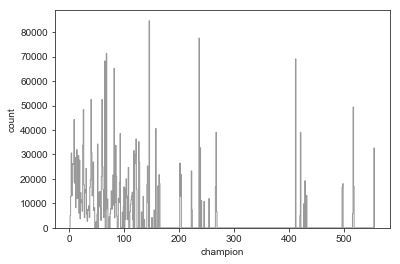

In [20]:
sns.set_style('ticks')
champ_sum = np.concatenate((lol_df['blue_champs0'],lol_df['blue_champs1'],lol_df['blue_champs2'],
            lol_df['blue_champs3'],lol_df['blue_champs4'],lol_df['red_champs0'],
            lol_df['red_champs1'],lol_df['red_champs2'],lol_df['red_champs3'],
            lol_df['red_champs4']),axis=None)

sns.distplot(champ_sum,bins=555,kde=False,hist_kws={'histtype':'step','color' :'Black'})
plt.xlabel('champion')
plt.ylabel('count')
plt.show()

## Define preprocess functions

In [21]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [22]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords(filename, examples, target_df,target_name):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    target_array = np.array(target_df[target_name])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i].tostring()
        red_champs = red_hero_array[:][i].tostring()
        target = target_array[i]
        
        # Create a feature
        if target_name=='blue_win':
            feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _int64_feature(target)}
        else:
            feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _float_feature(target)}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [23]:
def preprocess_features(lol_df):
    """Take lol_df and create a dataframe containing only the features for our model
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of champs for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['blue_champs'] = list(np.array(lol_df.loc[:,['blue_champs0',
                                                'blue_champs1','blue_champs2',
                                                'blue_champs3','blue_champs4']]).astype(int))
    processed_df['red_champs'] = list(np.array(lol_df.loc[:,['red_champs0',
                                    'red_champs1','red_champs2',
                                    'red_champs3','red_champs4']]).astype(int))

    return processed_df
    
def preprocess_targets_win(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model. (blue_win here)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    
    return target_df

def preprocess_targets_gold(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['gold_diff'] = (lol_df['blue_gold']-lol_df['red_gold'])/(lol_df['blue_gold']+lol_df['red_gold'])
    target_df['gold_diff'] = (target_df['gold_diff']-target_df['gold_diff'].mean())/target_df['gold_diff'].std()
    return target_df

#this can be easily modified for baron, dragon, or inhib kills
def preprocess_targets_towerkills(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized tower_kill difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (tower_kills)
    """
    tower_kills = np.array([])
    for blue_tow,red_tow in zip(lol_df['blue_tower_kills'],lol_df['red_tower_kills']):
        if blue_tow!=0 or red_tow!=0:
            tower_kills = np.append(tower_kills,(blue_tow-red_tow)/(blue_tow+red_tow))
        else:
            tower_kills = np.append(tower_kills,0)

    target_df = pd.DataFrame()
    target_df['tower_kills'] = tower_kills
    
    return target_df

### Visualize data for each set

In [24]:
plotting_df = lol_df

display.display(plotting_df.iloc[:train_len,:].describe())
display.display(plotting_df.iloc[train_len:train_len+test_len,:].describe())
display.display(plotting_df.iloc[train_len+test_len:,:].describe())

,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000,...,192813.000000,192813.000000,192813.000000,192813.000000,192813.00000,192813.000000,192813.000000,192813.000000,192813.000000,192813.000000
mean,0.484008,49919.690840,50336.863256,5.117440,5.252457,0.821599,0.852105,1.366158,1.564713,0.428763,...,130.034360,128.772827,131.253645,130.777785,130.87214,130.648084,130.657876,131.339484,129.879925,128.286366
std,0.499745,15123.023933,15284.502801,3.708032,3.742708,1.091140,1.095318,1.234386,1.287411,0.620760,...,135.052642,134.250160,135.809174,135.684361,135.88169,135.814460,135.483761,136.173608,134.923714,134.003945
min,0.000000,3520.000000,3585.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40203.000000,40525.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.00000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,50578.000000,51051.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,84.000000,84.000000,84.00000,84.000000,84.000000,84.000000,84.000000,84.000000
75%,1.000000,60068.000000,60649.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,154.000000,150.000000,157.000000,157.000000,157.00000,157.000000,157.000000,157.000000,157.000000,145.000000
max,1.000000,141001.000000,122758.000000,11.000000,11.000000,13.000000,10.000000,7.000000,7.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.00000,555.000000,555.000000,555.000000,555.000000,555.000000


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,...,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000,55090.000000
mean,0.481340,49827.123543,50245.590597,5.105718,5.238882,0.816319,0.843819,1.365674,1.559031,0.427119,...,129.966564,130.037412,130.899909,129.089472,131.381539,130.082356,130.446978,129.944872,129.384480,127.364404
std,0.499656,15108.392482,15258.845447,3.701648,3.737566,1.087742,1.089725,1.234348,1.283659,0.618940,...,135.413556,134.882842,135.704482,134.448433,136.374850,135.461840,135.503637,135.082660,135.121528,133.347407
min,0.000000,3495.000000,3575.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40135.000000,40416.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,38.000000
50%,0.000000,50495.500000,50952.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,84.000000,83.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
75%,1.000000,60018.000000,60580.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,154.000000,157.000000,157.000000,154.000000,157.000000,154.000000,157.000000,154.000000,154.000000,145.000000
max,1.000000,213912.000000,173857.000000,11.000000,11.000000,13.000000,10.000000,14.000000,7.000000,4.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,...,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000,27545.000000
mean,0.491523,50061.611835,50311.495444,5.178145,5.209766,0.840516,0.843311,1.378835,1.563623,0.434271,...,129.749646,129.998620,131.026647,130.772118,131.069341,130.323834,131.615139,130.942893,129.419495,129.380868
std,0.499937,15175.564240,15328.697774,3.709327,3.740619,1.102244,1.098472,1.231955,1.288969,0.624299,...,135.188856,135.960656,135.076778,135.387833,135.427324,135.503107,136.217908,136.198530,134.471231,135.350061
min,0.000000,3640.000000,3575.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40331.000000,40391.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,50745.000000,51044.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
75%,1.000000,60347.000000,60746.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,154.000000,150.000000,157.000000,157.000000,157.000000,154.000000,157.000000,157.000000,157.000000,150.000000
max,1.000000,141001.000000,122758.000000,11.000000,11.000000,11.000000,11.000000,7.000000,7.000000,4.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


### Export win tfrecord

In [25]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

train_features = preprocess_features(lol_df.iloc[:train_len,:])
train_targets = preprocess_targets_win(lol_df.iloc[:train_len,:])

test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
test_targets = preprocess_targets_win(lol_df.iloc[train_len:train_len+test_len,:])

validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])
validation_targets = preprocess_targets_win(lol_df.iloc[train_len+test_len:,:])

target_name='blue_win'
convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/192813
Train data: 10000/192813
Train data: 20000/192813
Train data: 30000/192813
Train data: 40000/192813
Train data: 50000/192813
Train data: 60000/192813
Train data: 70000/192813
Train data: 80000/192813
Train data: 90000/192813
Train data: 100000/192813
Train data: 110000/192813
Train data: 120000/192813
Train data: 130000/192813
Train data: 140000/192813
Train data: 150000/192813
Train data: 160000/192813
Train data: 170000/192813
Train data: 180000/192813
Train data: 190000/192813
Train data: 0/55090
Train data: 10000/55090
Train data: 20000/55090
Train data: 30000/55090
Train data: 40000/55090
Train data: 50000/55090
Train data: 0/27545
Train data: 10000/27545
Train data: 20000/27545


### Export gold tfrecord

In [26]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

train_features = preprocess_features(lol_df.iloc[:train_len,:])
train_targets = preprocess_targets_gold(lol_df.iloc[:train_len,:])

test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
test_targets = preprocess_targets_gold(lol_df.iloc[train_len:train_len+test_len,:])

validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])
validation_targets = preprocess_targets_gold(lol_df.iloc[train_len+test_len:,:])

target_name='gold_diff'
convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/192813
Train data: 10000/192813
Train data: 20000/192813
Train data: 30000/192813
Train data: 40000/192813
Train data: 50000/192813
Train data: 60000/192813
Train data: 70000/192813
Train data: 80000/192813
Train data: 90000/192813
Train data: 100000/192813
Train data: 110000/192813
Train data: 120000/192813
Train data: 130000/192813
Train data: 140000/192813
Train data: 150000/192813
Train data: 160000/192813
Train data: 170000/192813
Train data: 180000/192813
Train data: 190000/192813
Train data: 0/55090
Train data: 10000/55090
Train data: 20000/55090
Train data: 30000/55090
Train data: 40000/55090
Train data: 50000/55090
Train data: 0/27545
Train data: 10000/27545
Train data: 20000/27545
